# Tutorial 15 (JAX): Vision Transformers

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial15/Vision_Transformer.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial15/Vision_Transformer.ipynb)   
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/JAX/tutorial15)   
**PyTorch version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** This notebook is written in JAX+Flax. It is a 1-to-1 translation of the original notebook written in PyTorch+PyTorch Lightning with almost identical results. For an introduction to JAX, check out our [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html). Further, throughout the notebook, we comment on major differences to the PyTorch version and provide explanations for the major parts of the JAX code.
    
</div>

---

**Speed comparison**: We note the training times for all models in the PyTorch and the JAX implementation below (PyTorch v1.11, JAX v0.3.13). The models were trained on the same hardware (NVIDIA RTX3090, 24 core CPU) and we slightly adjusted the tutorials to use the exact same training settings (200 epochs, data loading parameters, evaluation schedule, etc.). Overall, the JAX implementation is just slightly faster (1.1x) than PyTorch.
    
| Models                |   PyTorch   |     JAX     |
|-----------------------|:-----------:|:-----------:|
| Vision Transformer    | 28min 40sec | 27min 10sec |

---

In this tutorial, we will take a closer look at a recent new trend: Transformers for Computer Vision. Since [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) successfully applied a Transformer on a variety of image recognition benchmarks, there have been an incredible amount of follow-up works showing that CNNs might not be optimal architecture for Computer Vision anymore. But how do Vision Transformers work exactly, and what benefits and drawbacks do they offer in contrast to CNNs? We will answer these questions by implementing a Vision Transformer ourselves and train it on the popular, small dataset CIFAR10. We will compare these results to the convolutional architectures of [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html). 

If you are not familiar with Transformers yet, take a look at [Tutorial 6](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html) where we discuss the fundamentals of Multi-Head Attention and Transformers. Let's start with importing our standard set of libraries.

In [1]:
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial
from PIL import Image
from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for progress bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial15_jax"

print("Device:", jax.devices()[0])

/tmp/ipykernel_2627394/2327484937.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: gpu:0


We provide a pre-trained Vision Transformer which we download in the next cell. However, Vision Transformers can be relatively quickly trained on CIFAR10 with an overall training time of less than an hour on an NVIDIA TitanRTX. Feel free to experiment with training your own Transformer once you went through the whole notebook.

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/"
# Files to download
pretrained_files = ["tutorial15/ViT.ckpt", "tutorial15/tensorboards/ViT/events.out.tfevents.ViT",
                    "tutorial5/tensorboards/ResNet/events.out.tfevents.resnet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name.split("/",1)[1])
    if "/" in file_name.split("/",1)[1]:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

We load the CIFAR10 dataset below. We use the same setup of the datasets and data augmentations as for the CNNs in Tutorial 5 to keep a fair comparison. The constants in the image normalization correspond to the values that scale and shift the data to a zero mean and standard deviation of one. 

In [3]:
# Transformations applied on each image => bring them into a numpy array
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for training and validation
train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=8,
                               persistent_workers=True)
val_loader   = data.DataLoader(val_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)
test_loader  = data.DataLoader(test_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


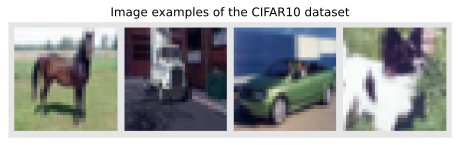

In [4]:
# Visualize some examples
def numpy_to_torch(array):
    array = jax.device_get(array)
    tensor = torch.from_numpy(array)
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

NUM_IMAGES = 4
CIFAR_images = np.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], axis=0)
img_grid = torchvision.utils.make_grid(numpy_to_torch(CIFAR_images), 
                                       nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## Transformers for image classification

Transformers have been originally proposed to process sets since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. To apply Transformers to sequences, we have simply added a positional encoding to the input feature vectors, and the model learned by itself what to do with it. So, why not do the same thing on images? This is exactly what [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) proposed in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches. As a preprocessing step, we split an image of, for example, $48\times 48$ pixels into 9 $16\times 16$ patches. Each of those patches is considered to be a "word"/"token" and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task. A nice GIF visualization of the architecture is shown below (figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="../../tutorial15/vit.gif" width="600px"></center>

We will walk step by step through the Vision Transformer, and implement all parts by ourselves. First, let's implement the image preprocessing: an image of size $N\times N$ has to be split into $(N/M)^2$ patches of size $M\times M$. These represent the input words to the Transformer. 

In [5]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    x = x.reshape(B, -1, *x.shape[3:])   # [B, H'*W', p_H, p_W, C]
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1) # [B, H'*W', p_H*p_W*C]
    return x

Let's take a look at how that works for our CIFAR examples above. For our images of size $32\times 32$, we choose a patch size of 4. Hence, we obtain sequences of 64 patches of size $4\times 4$. We visualize them below:

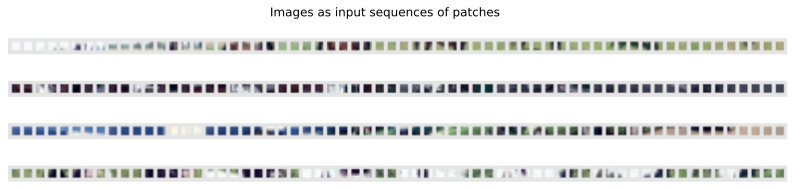

In [6]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(numpy_to_torch(img_patches[i]), 
                                           nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

Compared to the original images, it is much harder to recognize the objects from those patch lists now. Still, this is the input we provide to the Transformer for classifying the images. The model has to learn itself how it has to combine the patches to recognize the objects. The inductive bias in CNNs that an image is a grid of pixels, is lost in this input format.

After we have looked at the preprocessing, we can now start building the Transformer model. Since we have discussed the fundamentals of Multi-Head Attention in [Tutorial 6](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html), we will use the Flax module `nn.MultiHeadDotProductAttention` ([docs](https://flax.readthedocs.io/en/latest/_autosummary/flax.linen.MultiHeadDotProductAttention.html)) here. Further, we use the Pre-Layer Normalization version of the Transformer blocks proposed by [Ruibin Xiong et al.](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf) in 2020. The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage. A visualization of the difference between the standard Post-LN and the Pre-LN version is shown below.

<center width="100%"><img src="../../tutorial15/pre_layer_norm.svg" width="400px"></center>

The implementation of the Pre-LN attention block looks as follows:

In [7]:
class AttentionBlock(nn.Module):
    embed_dim : int   # Dimensionality of input and attention feature vectors
    hidden_dim : int  # Dimensionality of hidden layer in feed-forward network 
    num_heads : int   # Number of heads to use in the Multi-Head Attention block
    dropout_prob : float = 0.0  # Amount of dropout to apply in the feed-forward network
    
    def setup(self):
        self.attn = nn.MultiHeadDotProductAttention(num_heads=self.num_heads)
        self.linear = [
            nn.Dense(self.hidden_dim),
            nn.gelu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(self.embed_dim)
        ]
        self.layer_norm_1 = nn.LayerNorm()
        self.layer_norm_2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)
        
    def __call__(self, x, train=True):
        inp_x = self.layer_norm_1(x)
        attn_out = self.attn(inputs_q=inp_x, inputs_kv=inp_x)
        x = x + self.dropout(attn_out, deterministic=not train)
        
        linear_out = self.layer_norm_2(x)
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic=not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        return x

In [8]:
## Test AttentionBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention block
attnblock = AttentionBlock(embed_dim=128, hidden_dim=512, num_heads=4, dropout_prob=0.1)
# Initialize parameters of attention block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = attnblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = attnblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del attnblock, params

Out (3, 16, 128)


Now we have all modules ready to build our own Vision Transformer. Besides the Transformer encoder, we need the following modules:

* A **linear projection** layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each $M\times M$ patch independently as input.
* A **classification token** that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.
* Learnable **positional encodings** that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions.
* An **MLP head** that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.

With those components in mind, let's implement the full Vision Transformer below:

In [9]:
class VisionTransformer(nn.Module):
    embed_dim : int     # Dimensionality of input and attention feature vectors
    hidden_dim : int    # Dimensionality of hidden layer in feed-forward network 
    num_heads : int     # Number of heads to use in the Multi-Head Attention block
    num_channels : int  # Number of channels of the input (3 for RGB)
    num_layers : int    # Number of layers to use in the Transformer
    num_classes : int   # Number of classes to predict
    patch_size : int    # Number of pixels that the patches have per dimension
    num_patches : int   # Maximum number of patches an image can have
    dropout_prob : float = 0.0  # Amount of dropout to apply in the feed-forward network
    
    def setup(self):
        # Layers/Networks
        self.input_layer = nn.Dense(self.embed_dim)
        self.transformer = [AttentionBlock(self.embed_dim, 
                                           self.hidden_dim, 
                                           self.num_heads, 
                                           self.dropout_prob) for _ in range(self.num_layers)]
        self.mlp_head = nn.Sequential([
            nn.LayerNorm(),
            nn.Dense(self.num_classes)
        ])
        self.dropout = nn.Dropout(self.dropout_prob)
        
        # Parameters/Embeddings
        self.cls_token = self.param('cls_token', 
                                    nn.initializers.normal(stddev=1.0), 
                                    (1, 1, self.embed_dim))
        self.pos_embedding = self.param('pos_embedding', 
                                        nn.initializers.normal(stddev=1.0), 
                                        (1, 1+self.num_patches, self.embed_dim))
    
    
    def __call__(self, x, train=True):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, axis=0)
        x = jnp.concatenate([cls_token, x], axis=1)
        x = x + self.pos_embedding[:,:T+1]
        
        # Apply Transforrmer
        x = self.dropout(x, deterministic=not train)
        for attn_block in self.transformer:
            x = attn_block(x, train=train)
        
        # Perform classification prediction
        cls = x[:,0]
        out = self.mlp_head(cls)
        return out

In [10]:
## Test VisionTransformer implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (5, 32, 32, 3))
# Create vision transformer
visntrans = VisionTransformer(embed_dim=128, 
                              hidden_dim=512, 
                              num_heads=4, 
                              num_channels=3, 
                              num_layers=6,
                              num_classes=10, 
                              patch_size=4, 
                              num_patches=64,
                              dropout_prob=0.1)
# Initialize parameters of the Vision Transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = visntrans.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = visntrans.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del visntrans, params

Out (5, 10)


Finally, we can put everything into a trainer module as usual. We use `optax.adamw` as the optimizer, which is Adam with a corrected weight decay implementation. Since we use the Pre-LN Transformer version, we do not need to use a learning rate warmup stage anymore. Instead, we use the same learning rate scheduler as the CNNs in our previous tutorial on image classification.

In [11]:
class TrainerModule:

    def __init__(self, exmp_imgs, lr=1e-3, weight_decay=0.01, seed=42, **model_hparams):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.

        Inputs:
            exmp_imgs - Example imgs, used as input to initialize the model
            lr - Learning rate of the optimizer to use
            weight_decay - Weight decay to use in the optimizer
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.seed = seed
        self.rng = jax.random.PRNGKey(self.seed)
        # Create empty model. Note: no parameters yet
        self.model = VisionTransformer(**model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, 'ViT/')
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Function to calculate the classification loss and accuracy for a model
        def calculate_loss(params, rng, batch, train):
            imgs, labels = batch
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params},
                                      imgs,
                                      train=train,
                                      rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            # Get loss, gradients for loss, and other outputs of loss function
            (loss, (acc, rng)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        # Eval function
        def eval_step(state, rng, batch):
            # Return the accuracy for a single batch
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return rng, acc
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        self.rng, init_rng, dropout_init_rng = random.split(self.rng, 3)
        self.init_params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, 
                                           exmp_imgs, 
                                           train=True)['params']
        self.state = None

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.lr,
            boundaries_and_scales=
                {int(num_steps_per_epoch*num_epochs*0.6): 0.1,
                 int(num_steps_per_epoch*num_epochs*0.85): 0.1}
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adamw(lr_schedule, weight_decay=self.weight_decay)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(
                                       apply_fn=self.model.apply,
                                       params=self.init_params if self.state is None else self.state.params,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval accuracy
        best_eval = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(epoch=epoch_idx)
            if epoch_idx % 2 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/acc', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_eval:
                    best_eval = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(list)
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, acc = self.train_step(self.state, self.rng, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
        for key in metrics:
            avg_val = np.stack(jax.device_get(metrics[key])).mean()
            self.logger.add_scalar('train/'+key, avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        correct_class, count = 0, 0
        for batch in data_loader:
            self.rng, acc = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target=self.state.params,
                                    step=step,
                                    overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'ViT.ckpt'), target=None)
        self.state = train_state.TrainState.create(
                                       apply_fn=self.model.apply,
                                       params=params,
                                       tx=self.state.tx if self.state else optax.adamw(self.lr)  # Default optimizer
                                      )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'ViT.ckpt'))

## Experiments

Commonly, Vision Transformers are applied to large-scale image classification benchmarks such as ImageNet to leverage their full potential. However, here we take a step back and ask: can Vision Transformer also succeed on classical, small benchmarks such as CIFAR10? To find this out, we train a Vision Transformer from scratch on the CIFAR10 dataset. Let's first create a training function for our PyTorch Lightning module which also loads the pre-trained model if you have downloaded it above.

In [12]:
def train_model(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

Now, we can already start training our model. As seen in our implementation, we have a couple of hyperparameters that we have to set. When creating this notebook, we have performed a small grid search over hyperparameters and listed the best hyperparameters in the cell below. Nevertheless, it is worth discussing the influence that each hyperparameter has, and what intuition we have for choosing its value.

First, let's consider the patch size. The smaller we make the patches, the longer the input sequences to the Transformer become. While in general, this allows the Transformer to model more complex functions, it requires a longer computation time due to its quadratic memory usage in the attention layer. Furthermore, small patches can make the task more difficult since the Transformer has to learn which patches are close-by, and which are far away. We experimented with patch sizes of 2, 4, and 8 which gives us the input sequence lengths of 256, 64, and 16 respectively. We found 4 to result in the best performance and hence pick it below. 

Next, the embedding and hidden dimensionality have a similar impact on a Transformer as to an MLP. The larger the sizes, the more complex the model becomes, and the longer it takes to train. In Transformers, however, we have one more aspect to consider: the query-key sizes in the Multi-Head Attention layers. Each key has the feature dimensionality of `embed_dim/num_heads`. Considering that we have an input sequence length of 64, a minimum reasonable size for the key vectors is 16 or 32. Lower dimensionalities can restrain the possible attention maps too much. We observed that more than 8 heads are not necessary for the Transformer, and therefore pick an embedding dimensionality of `256`. The hidden dimensionality in the feed-forward networks is usually 2-4x larger than the embedding dimensionality, and thus we pick `512`. 

Finally, the learning rate for Transformers is usually relatively small, and in papers, a common value to use is 3e-5. However, since we work with a smaller dataset and have a potentially easier task, we found that we are able to increase the learning rate to 3e-4 without any problems. To reduce overfitting, we use a dropout value of 0.2. Remember that we also use small image augmentations as regularization during training.

Feel free to explore the hyperparameters yourself by changing the values below. In general, the Vision Transformer did not show to be too sensitive to the hyperparameter choices on the CIFAR10 dataset. 

In [13]:
model, results = train_model(exmp_imgs=next(iter(train_loader))[0],
                             embed_dim=256,
                             hidden_dim=512,
                             num_heads=8,
                             num_layers=6,
                             patch_size=4,
                             num_channels=3,
                             num_patches=64,
                             num_classes=10,
                             dropout_prob=0.2,
                             lr=3e-4)
print("ViT results", results)

ViT results {'val': 0.7856000661849976, 'test': 0.784000039100647}


The Vision Transformer achieves a validation and test performance of about 78%. In comparison, almost all CNN architectures that we have tested in [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html) obtained a classification performance of around 90%. This is a considerable gap and shows that although Vision Transformers perform strongly on ImageNet with potential pretraining, they cannot come close to simple CNNs on CIFAR10 when being trained from scratch. The differences between a CNN and Transformer can be well observed in the training curves. Let's look at them in a tensorboard below:

In [14]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir ../../saved_models/tutorial15_jax/tensorboards/

<center><img src="tensorboard_screenshot.png" width="100%"/></center>

The tensorboard compares the Vision Transformer to a ResNet trained on CIFAR10. When looking at the training losses, we see that the ResNet learns much more quickly in the first iterations. While the learning rate might have an influence on the initial learning speed, we see the same trend in the validation accuracy. The ResNet achieves the best performance of the Vision Transformer after just 5 epochs (2000 iterations). Further, while the ResNet training loss and validation accuracy have a similar trend, the validation performance of the Vision Transformers only marginally changes after 10k iterations while the training loss has almost just started going down. Yet, the Vision Transformer is also able to achieve close to 100% accuracy on the training set.

All those observed phenomenons can be explained with a concept that we have visited before: inductive biases. Convolutional Neural Networks have been designed with the assumption that images are translation invariant. Hence, we apply convolutions with shared filters across the image. Furthermore, a CNN architecture integrates the concept of distance in an image: two pixels that are close to each other are more related than two distant pixels. Local patterns are combined into larger patterns until we perform our classification prediction. All those aspects are inductive biases of a CNN. In contrast, a Vision Transformer does not know which two pixels are close to each other, and which are far apart. It has to learn this information solely from the sparse learning signal of the classification task. This is a huge disadvantage when we have a small dataset since such information is crucial for generalizing to an unseen test dataset. With large enough datasets and/or good pre-training, a Transformer can learn this information without the need for inductive biases, and instead is more flexible than a CNN. Especially long-distance relations between local patterns can be difficult to process in CNNs, while in Transformers, all patches have the distance of one. This is why Vision Transformers are so strong on large-scale datasets such as ImageNet but underperform a lot when being applied to a small dataset such as CIFAR10. 

## Conclusion

In this tutorial, we have implemented our own Vision Transformer from scratch and applied it to the task of image classification. Vision Transformers work by splitting an image into a sequence of smaller patches, use those as input to a standard Transformer encoder. While Vision Transformers achieved outstanding results on large-scale image recognition benchmarks such as ImageNet, they considerably underperform when being trained from scratch on small-scale datasets like CIFAR10. The reason is that in contrast to CNNs, Transformers do not have the inductive biases of translation invariance and the feature hierarchy (i.e. larger patterns consist of many smaller patterns). However, these aspects can be learned when enough data is provided, or the model has been pre-trained on other large-scale tasks. Considering that Vision Transformers have just been proposed end of 2020, there is likely a lot more to come on Transformers for Computer Vision.


### References

Dosovitskiy, Alexey, et al. "An image is worth 16x16 words: Transformers for image recognition at scale." International Conference on Learning Representations (2021). [link](https://arxiv.org/pdf/2010.11929.pdf)

Chen, Xiangning, et al. "When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations." arXiv preprint arXiv:2106.01548 (2021). [link](https://arxiv.org/abs/2106.01548)

Tolstikhin, Ilya, et al. "MLP-mixer: An all-MLP Architecture for Vision." arXiv preprint arXiv:2105.01601 (2021). [link](https://arxiv.org/abs/2105.01601)

Xiong, Ruibin, et al. "On layer normalization in the transformer architecture." International Conference on Machine Learning. PMLR, 2020. [link](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---